In [1]:
import gym
import scipy.optimize
import roboschool
from agent_file import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')

In [2]:
class action_space(object):
    def __init__(self, env):
        self.env = env
        self.high = np.array([ 1,  1,  1,  1,  1])
        self.low = -np.array([ 1,  1,  1,  1,  1])
        self.shape = env.observation_space.shape
    
    def sample(self):
    
        return self.env.observation_space.sample()
        
        
class adversial_env(object):
    def __init__(self):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.ratio = 1
        self.threshold = np.array([ 0.13973436,  0.07678319,  0.00016729,  0.00786861,  0.02336518])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#(np.abs(st[3])-0.00786861)*100
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        #obs = np.clip(a,-1,1)*self.threshold*self.ratio + self.obsr
        obs = np.array([ 0.13973436,  0.07678319,  0.00016729,  0.00786861,  0.02336518]) + self.obsr
        
        ac = self.agent.act(obs)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
            
        
        final_r = self.reward(self.obsr)
        if done and self.epi_num < self.max_turn:
            final_r = 15 # terminal cost 
        
        self.total_score += final_r
        return self.obsr, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,3,1)
        plt.plot(self.score_list[0:])
        plt.xlabel('episodes')
        plt.ylabel('cumulative reward')
        plt.subplot(1,3,2)
        plt.plot(self.rvg_list[0:])
        plt.xlabel('episodes')
        plt.ylabel('running average reward')
        plt.subplot(1,3,3)
        plt.plot(self.epi_list)
        plt.xlabel('episodes')
        plt.ylabel('number of time steps')
        plt.show()

# define an observer (new agent)

In [3]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 5000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 60
        
args = par()
env = adversial_env()
agn = agent(env, args)
agn.load_model('agent_model/adversarial_agent2_distr')

[2018-01-27 04:40:11,054] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [4]:
agn.learn()

60.6095298783 [60.609529878303874] [251]
Episode 0	Last reward: 75.60727954930917	Average reward 75.61


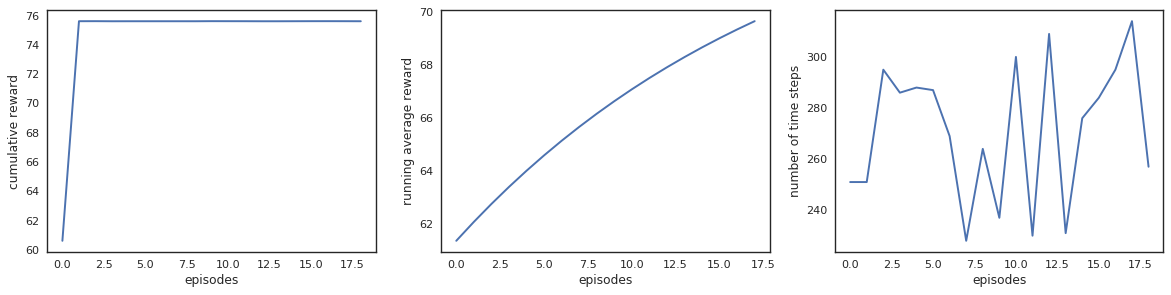

In [5]:
env.result_plot()

# Agent evaluation

In [6]:
env = adversial_env()
for i in range(10):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        print(np.clip(a,-1,1))
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-01-27 04:40:14,085] Making new env: RoboschoolInvertedPendulum-v1


[ 0.0084275   0.0356499  -0.01616385 -0.0070077   0.0072964 ]
[ 0.01444555  0.03218791 -0.02000169 -0.01128037  0.00657123]
[ 0.01551997  0.03114094 -0.0213453  -0.01232691  0.00734634]
[ 0.01680411  0.02986028 -0.02277335 -0.01356611  0.0079884 ]
[ 0.018156    0.02840909 -0.02421121 -0.01490818  0.00853402]
[ 0.01952537  0.02679704 -0.02562068 -0.01631388  0.00898443]
[ 0.02076536  0.02516602 -0.02692086 -0.01762216  0.00941539]
[ 0.02177563  0.0236732  -0.02806536 -0.0186865   0.00991559]
[ 0.0226542   0.02224858 -0.02908869 -0.01956704  0.01043342]
[ 0.02344615  0.02085404 -0.03000164 -0.02029076  0.01093842]
[ 0.02417823  0.01946155 -0.03080635 -0.02087345  0.01140587]
[ 0.02485132  0.01807348 -0.03149846 -0.02130843  0.01183436]
[ 0.02546717  0.01669178 -0.03207586 -0.02159201  0.01222365]
[ 0.02602893  0.01531711 -0.03253871 -0.02172415  0.01257378]
[ 0.02654045  0.01394958 -0.03288922 -0.02170792  0.0128854 ]
[ 0.02700594  0.01258904 -0.03313137 -0.02154915  0.01315981]
[ 0.0274

[ 0.01683469 -0.00374735 -0.00192196  0.02641237 -0.02264372]
[ 0.01684915 -0.0036676  -0.00189424  0.02642781 -0.02279464]
[ 0.01686395 -0.00358916 -0.00186551  0.02644365 -0.02294409]
[ 0.01687908 -0.003512   -0.00183578  0.02645987 -0.02309209]
[ 0.01689451 -0.00343608 -0.00180503  0.02647649 -0.02323866]
[ 0.01691024 -0.00336138 -0.00177328  0.02649348 -0.02338383]
[ 0.01692624 -0.00328786 -0.00174052  0.02651085 -0.02352762]
[ 0.01694249 -0.0032155  -0.00170676  0.02652859 -0.02367006]
[ 0.01695898 -0.00314425 -0.001672    0.02654668 -0.02381117]
[ 0.01697569 -0.0030741  -0.00163626  0.02656512 -0.02395097]
[ 0.0169926  -0.00300501 -0.00159955  0.02658389 -0.02408949]
[ 0.01700971 -0.00293695 -0.00156188  0.02660297 -0.02422674]
[ 0.017027   -0.00286991 -0.00152326  0.02662235 -0.02436276]
[ 0.01704447 -0.00280384 -0.00148372  0.02664202 -0.02449755]
[ 0.01706209 -0.00273872 -0.00144327  0.02666194 -0.02463114]
[ 0.01707987 -0.00267453 -0.00140193  0.0266821  -0.02476355]
[ 0.0170

[ 0.01586339 -0.00852849 -0.0010106   0.02728305 -0.01420609]
[ 0.01588379 -0.0083537  -0.00109848  0.02720183 -0.01448314]
[ 0.0159029  -0.00818143 -0.00118344  0.02712338 -0.01475392]
[ 0.01592151 -0.00801208 -0.00126579  0.02704749 -0.01501894]
[ 0.01594025 -0.00784597 -0.00134575  0.02697402 -0.01527865]
[ 0.01595959 -0.00768333 -0.00142342  0.02690292 -0.01553342]
[ 0.01598106 -0.00752502 -0.0014991   0.02683406 -0.01578411]
[ 0.01600741 -0.00737258 -0.00157323  0.02676738 -0.01603218]
[ 0.01603777 -0.00722558 -0.00164509  0.02670344 -0.01627739]
[ 0.01607133 -0.00708362 -0.0017141   0.0266427  -0.01651953]
[ 0.01610742 -0.00694636 -0.00177975  0.02658553 -0.01675847]
[ 0.01614544 -0.00681346 -0.00184162  0.02653224 -0.0169941 ]
[ 0.01618486 -0.00668466 -0.00189938  0.02648304 -0.01722636]
[ 0.01622522 -0.00655966 -0.00195273  0.02643811 -0.01745525]
[ 0.01626614 -0.00643824 -0.00200148  0.02639756 -0.01768074]
[ 0.01630726 -0.00632017 -0.00204546  0.02636147 -0.01790289]
[ 0.0163

[ 0.02839729 -0.02345253 -0.01814164  0.00660893  0.01340998]
[ 0.02850591 -0.02363189 -0.01795465  0.00693108  0.01310769]
[ 0.02860976 -0.02381196 -0.01775127  0.00726322  0.01280062]
[ 0.02870273 -0.02399189 -0.01753077  0.00760645  0.0124961 ]
[ 0.02877775 -0.02417022 -0.017293    0.00796165  0.01220252]
[ 0.02883357 -0.02434562 -0.01703875  0.00832858  0.01192107]
[ 0.02886958 -0.02451679 -0.01676892  0.00870685  0.01165207]
[ 0.02888561 -0.0246825  -0.01648449  0.00909599  0.01139531]
[ 0.02888174 -0.02484161 -0.01618643  0.00949549  0.01115022]
[ 0.02885824 -0.02499303 -0.01587572  0.0099048   0.01091598]
[ 0.02881553 -0.02513581 -0.01555333  0.01032335  0.01069161]
[ 0.02875413 -0.02526901 -0.01522016  0.01075059  0.01047601]
[ 0.02867534 -0.02539193 -0.01487718  0.01118577  0.01026723]
[ 0.02858404 -0.02550449 -0.0145256   0.01162745  0.01005942]
[ 0.02849435 -0.02560844 -0.01416721  0.01207234  0.00983686]
[ 0.02841789 -0.02570631 -0.01380229  0.01251861  0.00958696]
[ 0.0283

[ 0.00534523  0.01183494 -0.01780664 -0.0173837   0.01679785]
[ 0.00668091  0.01150467 -0.01860935 -0.01760952  0.01683827]
[ 0.00795218  0.01112418 -0.01934215 -0.017785    0.01687903]
[ 0.00921534  0.01068197 -0.02001398 -0.01792079  0.01687771]
[ 0.01040929  0.01019012 -0.02061271 -0.01800152  0.01687398]
[ 0.01154005  0.00965068 -0.0211408  -0.01802757  0.01686319]
[ 0.01262126  0.00906301 -0.02160033 -0.01799958  0.01683349]
[ 0.01363262  0.00843433 -0.02198985 -0.01791281  0.01680169]
[ 0.01457492  0.0077689  -0.02231208 -0.01776759  0.01676935]
[ 0.01545138  0.0070705  -0.02257018 -0.01756512  0.01673633]
[ 0.01629513  0.00633419 -0.02276653 -0.01730755  0.01667131]
[ 0.01694503  0.0056067  -0.02290701 -0.01699399  0.01674812]
[ 0.01752811  0.00487298 -0.02300879 -0.01664501  0.01685015]
[ 0.01807095  0.00413132 -0.02307654 -0.01626598  0.01695317]
[ 0.01856724  0.00338605 -0.02311385 -0.01586083  0.01706731]
[ 0.01903116  0.00263702 -0.02312388 -0.01543319  0.01717946]
[ 0.0194

[ 0.01665973 -0.00494493 -0.00217691  0.02625957 -0.02046843]
[ 0.016672   -0.00484587 -0.0021652   0.02626732 -0.02064353]
[ 0.01668387 -0.0047482  -0.00215196  0.02627591 -0.02081635]
[ 0.01669556 -0.00465197 -0.00213732  0.02628524 -0.02098703]
[ 0.01670724 -0.00455722 -0.00212141  0.02629521 -0.02115566]
[ 0.01671904 -0.00446398 -0.0021043   0.02630576 -0.02132233]
[ 0.01673105 -0.00437225 -0.00208606  0.02631683 -0.02148712]
[ 0.01674334 -0.00428204 -0.00206672  0.02632839 -0.02165009]
[ 0.01675595 -0.00419333 -0.00204631  0.02634043 -0.0218113 ]
[ 0.01676891 -0.00410611 -0.00202483  0.02635294 -0.02197078]
[ 0.01678223 -0.00402036 -0.00200231  0.02636589 -0.0221286 ]
[ 0.01679591 -0.00393606 -0.00197874  0.0263793  -0.02228478]
[ 0.01680996 -0.00385318 -0.00195412  0.02639315 -0.02243937]
[ 0.01682437 -0.00377169 -0.00192845  0.02640744 -0.02259239]
[ 0.01683912 -0.00369155 -0.00190173  0.02642219 -0.02274388]
[ 0.01685421 -0.00361275 -0.00187396  0.02643737 -0.02289387]
[ 0.0168

[ 0.01549307 -0.00992757 -0.00014562  0.0280672  -0.01166014]
[ 0.01558154 -0.00976366 -0.00028783  0.02793914 -0.01202256]
[ 0.01565325 -0.00959387 -0.00041804  0.02782141 -0.01236901]
[ 0.01571127 -0.00941998 -0.00053817  0.02771234 -0.0127015 ]
[ 0.01575824 -0.00924347 -0.00064989  0.02761051 -0.01302171]
[ 0.01579648 -0.00906558 -0.00075464  0.0275147  -0.01333111]
[ 0.01582798 -0.0088874  -0.0008536   0.02742395 -0.01363092]
[ 0.01585444 -0.00870979 -0.00094773  0.02733744 -0.01392217]
[ 0.0158773  -0.00853352 -0.00103783  0.02725455 -0.01420574]
[ 0.01589774 -0.0083592  -0.00112451  0.02717481 -0.01448239]
[ 0.01591677 -0.00818732 -0.00120821  0.02709787 -0.01475275]
[ 0.01593519 -0.0080183  -0.00128927  0.02702349 -0.01501735]
[ 0.01595363 -0.00785245 -0.00136791  0.02695152 -0.01527662]
[ 0.0159726  -0.00769003 -0.00144426  0.0268819  -0.01553096]
[ 0.01599301 -0.00753153 -0.00151849  0.02681456 -0.01578093]
[ 0.01601843 -0.00737894 -0.00159129  0.02674927 -0.01602837]
[ 0.0160

[ 0.02209601 -0.02385428 -0.00142886  0.02647519  0.003251  ]
[ 0.02177742 -0.02350049 -0.00096305  0.02698433  0.00281624]
[ 0.02146241 -0.02313155 -0.0005037   0.02748326  0.00236891]
[  2.11516627e-02  -2.27484439e-02  -5.14580360e-05   2.79710805e-02
   1.90951030e-03]
[ 0.02084283 -0.02235062  0.00039371  0.02844783  0.00144041]
[ 0.02046339 -0.02189905  0.00084658  0.02893379  0.00100459]
[ 0.02002401 -0.02139563  0.00129444  0.02941518  0.00059783]
[ 0.01954592 -0.02084984  0.00172272  0.02987551  0.00021103]
[ 0.01903377 -0.02026351  0.00212203  0.03030458 -0.0001548 ]
[ 0.01850313 -0.01964624  0.00248119  0.03068973 -0.00050408]
[ 0.01797245 -0.01901131  0.00279065  0.03102007 -0.00084276]
[ 0.01745591 -0.01837096  0.00304453  0.03128893 -0.001175  ]
[ 0.01700739 -0.01776536  0.00323478  0.03148729 -0.0015292 ]
[ 0.01661904 -0.01719468  0.0033696   0.03162461 -0.00190119]
[ 0.01628394 -0.01665826  0.00345622  0.03170919 -0.00228758]
[ 0.01599605 -0.0161548   0.00350098  0.0317

[ 0.02822844 -0.02249429 -0.01914317  0.00457418  0.01501599]
[ 0.02831509 -0.02270296 -0.01900302  0.00488122  0.0147959 ]
[ 0.02839622 -0.02290737 -0.01885377  0.00519212  0.01457369]
[ 0.02846688 -0.02310708 -0.01869523  0.00550722  0.01435587]
[ 0.02852555 -0.0233015  -0.0185277   0.00582648  0.01414441]
[ 0.02857122 -0.02348997 -0.01835168  0.00614971  0.01394058]
[ 0.02860395 -0.02367185 -0.01816776  0.00647663  0.01374424]
[ 0.02862398 -0.02384659 -0.01797655  0.00680695  0.01355495]
[ 0.02867332 -0.02401778 -0.01777965  0.00713697  0.01331863]
[ 0.0287602  -0.02418938 -0.01757338  0.0074687   0.01302442]
[ 0.02886007 -0.02436248 -0.017352    0.0078081   0.01270277]
[ 0.02893426 -0.02453437 -0.01711167  0.00816148  0.01240166]
[ 0.02898439 -0.0247034  -0.01685405  0.00852775  0.01211872]
[ 0.0290117  -0.0248681  -0.0165806   0.00890597  0.011852  ]
[ 0.02901719 -0.02502717 -0.01629261  0.00929531  0.01159979]
[ 0.02900175 -0.02517941 -0.01599128  0.00969503  0.01136055]
[ 0.0289

[  1.04151098e-05   3.57922863e-02  -1.53134580e-02   2.62330797e-02
   3.84975656e-03]
[-0.00823975 -0.00257742  0.02336922  0.01742029  0.00936036]
[-0.01996421  0.00548116  0.0254227   0.01820392  0.00956649]
[-0.02536196  0.00943462  0.02417312  0.01713992  0.01023576]
[-0.02508259  0.0085558   0.02244928  0.01487224  0.01046616]
[-0.02471184  0.00785242  0.02071946  0.01268498  0.01075072]
[-0.02426412  0.00732638  0.01898519  0.01057927  0.01108071]
[-0.02371443  0.00694452  0.01724801  0.00854951  0.01144137]
[-0.02307253  0.0067003   0.01551074  0.00659855  0.01182399]
[-0.02230688  0.00655581  0.01377533  0.00472259  0.01221266]
[-0.02143878  0.00651057  0.01204745  0.00292997  0.01260014]
[-0.02049491  0.00656347  0.01033265  0.00122781  0.01298192]
[-0.01947983  0.00669745  0.00863432 -0.00038284  0.01335116]
[-0.01841606  0.00690485  0.0069578  -0.00189836  0.01370657]
[-0.01739106  0.00720795  0.00531495 -0.00330684  0.01406751]
[-0.01626529  0.00752427  0.00368586 -0.0046

[ 0.01623895 -0.0064759  -0.00196222  0.02643308 -0.0176042 ]
[ 0.01628056 -0.00635647 -0.00200921  0.02639397 -0.01782801]
[ 0.01632219 -0.00624028 -0.00205131  0.02635939 -0.01804845]
[ 0.01636357 -0.00612712 -0.00208843  0.02632935 -0.01826558]
[ 0.01640447 -0.0060168  -0.00212051  0.02630381 -0.01847947]
[ 0.01644469 -0.00590915 -0.00214755  0.02628274 -0.01869021]
[ 0.01648408 -0.005804   -0.00216956  0.02626604 -0.01889787]
[ 0.01651799 -0.00569885 -0.00218536  0.02625424 -0.01910072]
[ 0.01654673 -0.00559365 -0.00219565  0.02624669 -0.01929899]
[ 0.01657145 -0.00548881 -0.00220132  0.02624264 -0.01949323]
[ 0.01659308 -0.00538464 -0.00220307  0.02624147 -0.01968386]
[ 0.01661164 -0.005281   -0.00220129  0.02624282 -0.01987096]
[ 0.01662784 -0.00517813 -0.00219654  0.02624619 -0.02005485]
[ 0.01664232 -0.00507625 -0.00218931  0.0262512  -0.02023584]
[ 0.01665561 -0.00497552 -0.00217997  0.02625753 -0.02041415]
[ 0.01666809 -0.00487606 -0.00216881  0.02626495 -0.02058998]
[ 0.0166

[ 0.02682046 -0.02581142 -0.0099112   0.01703812  0.0070731 ]
[ 0.02661886 -0.02578322 -0.00945351  0.01756528  0.00679981]
[ 0.02640208 -0.02573868 -0.008987    0.01810077  0.00652412]
[ 0.0261711  -0.02567705 -0.0085126   0.01864361  0.0062448 ]
[ 0.02592697 -0.02559767 -0.00803128  0.01919276  0.00596064]
[ 0.02567078 -0.02549995 -0.00754399  0.01974715  0.00567047]
[ 0.02540365 -0.02538339 -0.00705168  0.02030568  0.00537319]
[ 0.02512672 -0.0252476  -0.00655533  0.02086722  0.00506779]
[ 0.02484117 -0.02509228 -0.00605588  0.0214306   0.00475334]
[ 0.02454817 -0.02491726 -0.00555427  0.02199467  0.004429  ]
[ 0.02424886 -0.02472244 -0.00505147  0.02255822  0.00409405]
[ 0.02394441 -0.02450789 -0.00454839  0.02312007  0.0037479 ]
[ 0.02363594 -0.02427375 -0.00404597  0.02367902  0.00339006]
[ 0.02332456 -0.0240203  -0.0035451   0.02423389  0.00302018]
[ 0.02301133 -0.02374793 -0.00304667  0.02478352  0.00263804]
[ 0.02269728 -0.02345715 -0.00255155  0.02532674  0.00224355]
[ 0.0223

[ 0.02559088 -0.01621854 -0.02017943 -0.0017493   0.01765709]
[ 0.02569696 -0.01663165 -0.02007594 -0.00139683  0.01758952]
[ 0.02579898 -0.01703095 -0.01997435 -0.00105036  0.0175184 ]
[ 0.02589437 -0.0174165  -0.01987466 -0.00071017  0.01744758]
[ 0.025983   -0.01778818 -0.01977708 -0.00037639  0.01737761]
[  2.60651373e-02  -1.81459039e-02  -1.96818197e-02  -4.90525713e-05
   1.73084675e-02]
[ 0.02611756 -0.01848877 -0.01958968  0.00026816  0.01727297]
[ 0.02613855 -0.01881427 -0.01950349  0.00057289  0.01727486]
[ 0.02615194 -0.01912066 -0.01942589  0.00086616  0.01728233]
[ 0.02616356 -0.01940802 -0.01935732  0.00114852  0.0172877 ]
[ 0.02617473 -0.01967684 -0.01929767  0.00142036  0.01728929]
[ 0.02618581 -0.0199277  -0.01924674  0.00168205  0.0172867 ]
[ 0.02619693 -0.02016119 -0.01920429  0.00193396  0.01727983]
[ 0.02620816 -0.02037791 -0.01917007  0.00217643  0.01726861]
[ 0.02621957 -0.02057841 -0.01914384  0.00240979  0.01725304]
[ 0.02623118 -0.02076327 -0.01912536  0.0026

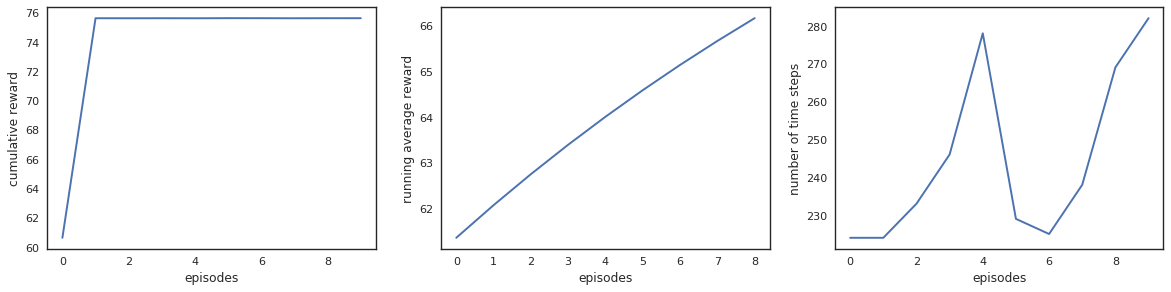

In [7]:
env.result_plot()

# Save model

In [8]:
agn.save_model('agent_model/adversarial_agent2_distr')

In [9]:
env.total_score

75.608537105319556